<div style="background-color:#1e1e1e; color:#f0f0f0; padding:12px; border-radius:8px; line-height:1.5; font-size:16px;">

<h2 style="margin-top:0; color:#ffffff;">Options</h2>

The goal of this notebook is to explore several options strategies. To do so, we use both 
<span style="color:#7CFC00;"><b>yahoo finance (yfinance)</b></span> and 
<span style="color:#00CED1;"><b>polygon.io</b></span> data.<br><br>

We lean mostly on the polygon data, which means that each user of this notebook will have to create and store a 
<span style="color:#00CED1;"><b>polygon API key</b></span> somewhere on their local machine.<br><br>

<b style="color:#FF6F61;">Note:</b> The polygon API key that I 
<span style="color:#DA70D6;"><b>(Mike Kovacevich)</b></span> have used to gather the data below corresponds to one of Polygon's paid tiers 
(I think it is $30 a month or something). The goal was to get access to options contracts and be able to analyze them via the "Greeks" and Implied Volatility

</div>


In [1]:
#Install any necessary packages here rather than the command line
!uv pip install dotenv polygon-api-client mplfinance 
!uv pip install --upgrade scipy statsmodels

Using Python 3.12.9 environment at: /Users/michaelkovacevich/projects/ad-hoc/.venv
Audited 3 packages in 86ms
Using Python 3.12.9 environment at: /Users/michaelkovacevich/projects/ad-hoc/.venv
Resolved 10 packages in 284ms                                        
Audited 10 packages in 1ms


In [2]:
import os
import requests
from dotenv import load_dotenv
from datetime import date, datetime, timedelta
from datetime import timezone as dt_timezone
from dateutil.relativedelta import relativedelta
import mplfinance as mpf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy import optimize
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

#Retrieve the API key from another directory that is NOT uploaded to Github
load_dotenv()
API_KEY = os.getenv("POLYGON_API_KEY")

Below we create functions that load options contracts for a given stock ticker (e.g AAPL, AAL, etc). We look at a specific date range of contracts since we want to analyze mediumish term contracts

In [3]:
def analyze_option_contract(underlying: str, option_ticker: str, api_key: str):
    """Fetch and display Greeks and IV for a specific option contract."""
    url = f"https://api.polygon.io/v3/snapshot/options/{underlying}/{option_ticker}?apiKey={api_key}"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"[WARN] Could not fetch option {option_ticker}: {e}")
        return None

    data = response.json()
    results = data.get("results", {})
    if not results:
        print(f"[WARN] No results for option {option_ticker}")
        return None

    greeks = results.get("greeks", {})
    implied_volatility = results.get("implied_volatility")

    print("\nOption Details:")
    print(f"Ticker: {option_ticker}")
    print(f"Delta: {greeks.get('delta')}")
    print(f"Gamma: {greeks.get('gamma')}")
    print(f"Theta: {greeks.get('theta')}")
    print(f"Vega: {greeks.get('vega')}")
    print(f"Implied Volatility: {implied_volatility}")

    return results

def get_current_stock_price(ticker: str) -> float:
    """Fetch current stock price from Polygon."""
    url = f"https://api.polygon.io/v2/last/trade/{ticker}?apiKey={API_KEY}"
    resp = requests.get(url)
    resp.raise_for_status()
    return resp.json()["last"]["price"]

def get_option_contracts(ticker: str, limit: int = 1000, min_days: int = 20, max_days: int = 120):
    """Fetch option contracts for a given ticker within a specified expiration range."""
    base_url = "https://api.polygon.io/v3/reference/options/contracts"
    params = {
        "underlying_ticker": ticker,
        "limit": limit,
        "apiKey": API_KEY
    }

    today = datetime.now(dt_timezone.utc).date()
    min_exp = today + timedelta(days=min_days)
    max_exp = today + timedelta(days=max_days)

    contracts = []
    url = base_url

    while url:
        response = requests.get(url, params=params)
        data = response.json()

        if not data.get("results"):
            break

        for c in data["results"]:
            exp_date = datetime.strptime(c["expiration_date"], "%Y-%m-%d").date()
            if min_exp <= exp_date <= max_exp:
                try:
                    greeks_data = analyze_option_contract(ticker, c["ticker"], API_KEY)
                    if greeks_data:
                        c["greeks"] = greeks_data
                        contracts.append(c)
                except Exception as e:
                    print(f"[WARN] Skipping {c['ticker']} due to error: {e}")
                    continue

        url = data.get("next_url")
        params = {}  # Only needed for the first request

    return contracts

def print_options_contracts(contracts):
    if not contracts:
        print("No option contracts to display.")
        return

    print(f"{'Index':<6} {'Ticker':<25} {'Strike':<10} {'Type':<6} {'Style':<10} {'Expires':<12} {'Exchange'}")
    print("-" * 100)
    for idx, c in enumerate(contracts):
        print(f"{idx:<6} {c['ticker']:<25} {c['strike_price']:<10} {c['contract_type']:<6} {c['exercise_style']:<10} {c['expiration_date']:<12} {c['primary_exchange']}")

def get_latest_closing_price(
    symbol: str,
    from_date: str,
    to_date: str,
    api_key: str,
    multiplier: int = 1,
    timespan: str = "day"
) -> float | None:
    """
    Returns the latest closing price for the given ticker between from_date and to_date.
    """
    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/{multiplier}/{timespan}/{from_date}/{to_date}"
    params = {
        "adjusted": "true",
        "sort": "desc",   # Sort descending so latest is first
        "limit": 1,       # Only need the latest
        "apiKey": api_key
    }

    res = requests.get(url, params=params)
    data = res.json()

    if "results" in data and data["results"]:
        latest = data["results"][0]
        return latest["c"]  # Closing price
    else:
        print("Error or no data:", data)
        return None


In [4]:
#The code below is more script like rather than a notebook - should be cleaned up
ticker = "VOO"
contracts = get_option_contracts(ticker)


Option Details:
Ticker: O:VOO250905C00470000
Delta: 0.9765812599676789
Gamma: 0.0007489846119883646
Theta: -0.12134628858328995
Vega: 0.06538224456084989
Implied Volatility: 0.4872831172547113

Option Details:
Ticker: O:VOO250905C00475000
Delta: 0.9849536591823781
Gamma: 0.0005785919453541188
Theta: -0.08624768181901758
Vega: 0.06519300209368746
Implied Volatility: 0.4213166461264357

Option Details:
Ticker: O:VOO250905C00480000
Delta: 0.9703725610719428
Gamma: 0.0009537329180120907
Theta: -0.13742602624699024
Vega: 0.13223863099740962
Implied Volatility: 0.468675618012667

Option Details:
Ticker: O:VOO250905C00485000
Delta: 0.9736370229962297
Gamma: 0.0009360256788103564
Theta: -0.12267514370151152
Vega: 0.06626798039384539
Implied Volatility: 0.43512402256157845

Option Details:
Ticker: O:VOO250905C00490000
Delta: 0.9715594084901024
Gamma: 0.001033737872921633
Theta: -0.12520308895925047
Vega: 0.1331256915991635
Implied Volatility: 0.41898553032673014

Option Details:
Ticker: O:VOO2

In [5]:
valid_contracts_idx = [
    i for i, contracts in enumerate(contracts)
    if contracts.get('greeks', {}).get('greeks')
]
valid_contracts = [contracts[i] for i in valid_contracts_idx]

In [6]:
valid_contracts[0]

{'cfi': 'OCASPS',
 'contract_type': 'call',
 'exercise_style': 'american',
 'expiration_date': '2025-09-05',
 'primary_exchange': 'BATO',
 'shares_per_contract': 100,
 'strike_price': 470,
 'ticker': 'O:VOO250905C00470000',
 'underlying_ticker': 'VOO',
 'greeks': {'day': {},
  'details': {'contract_type': 'call',
   'exercise_style': 'american',
   'expiration_date': '2025-09-05',
   'shares_per_contract': 100,
   'strike_price': 470,
   'ticker': 'O:VOO250905C00470000'},
  'greeks': {'delta': 0.9765812599676789,
   'gamma': 0.0007489846119883646,
   'theta': -0.12134628858328995,
   'vega': 0.06538224456084989},
  'implied_volatility': 0.4872831172547113,
  'open_interest': 0,
  'underlying_asset': {'ticker': 'VOO'}}}

Lets further look at the actual stock movement of a given ticker symbol

In [7]:
def get_latest_closing_price(
    symbol: str,
    from_date: str,
    to_date: str,
    api_key: str,
    multiplier: int = 1,
    timespan: str = "day"
) -> float | None:
    """
    Returns the latest closing price for the given ticker between from_date and to_date.
    """
    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/{multiplier}/{timespan}/{from_date}/{to_date}"
    params = {
        "adjusted": "true",
        "sort": "desc",   # Sort descending so latest is first
        "limit": 1,       # Only need the latest
        "apiKey": api_key
    }

    res = requests.get(url, params=params)
    data = res.json()

    if "results" in data and data["results"]:
        latest = data["results"][0]
        return latest["c"]  # Closing price
    else:
        print("Error or no data:", data)
        return None

today_date = date.today().strftime("%Y-%m-%d")
previous_date = (date.fromisoformat(today_date) - relativedelta(years=2)).isoformat()

price = get_latest_closing_price(ticker, previous_date, today_date, API_KEY)

In [8]:
price

590.78

In [9]:
multiplier = 1
timespan = "day"

url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{multiplier}/{timespan}/{previous_date}/{today_date}"
params = {
    "adjusted": "true",
    "sort": "asc",     # or "desc"
    "limit": 00,
    "apiKey": API_KEY
}

res = requests.get(url, params=params)
data = res.json()

# Preview the results
if "results" in data:
    for candle in data["results"]:
        t = datetime.fromtimestamp(candle["t"] / 1000)
        print(f"{t.date()} - O: {candle['o']} H: {candle['h']} L: {candle['l']} C: {candle['c']} V: {candle['v']}")
else:
    print("Error or no data:", data)

2023-08-14 - O: 408.56 H: 411.74 L: 408.31 C: 411.72 V: 2772912.0
2023-08-15 - O: 410.09 H: 411.7125 L: 406.41 C: 407 V: 4686119.0
2023-08-16 - O: 406.59 H: 408.11 L: 403.87 C: 403.99 V: 3353653.0
2023-08-17 - O: 405.33 H: 405.58 L: 400.37 C: 400.72 V: 7102504.0
2023-08-18 - O: 398.17 H: 402.02 L: 397.85 C: 401.09 V: 4157667.0
2023-08-21 - O: 402.14 H: 404.39 L: 399.99 C: 403.74 V: 3292434.0
2023-08-22 - O: 405.35 H: 405.4 L: 402.06 C: 402.61 V: 2648051.0
2023-08-23 - O: 403.56 H: 407.67 L: 403.47 C: 406.95 V: 3249964.0
2023-08-24 - O: 408.6 H: 409.079 L: 401.4 C: 401.54 V: 3458791.0
2023-08-25 - O: 403.08 H: 405.8 L: 399.71 C: 404.2 V: 4417835.0
2023-08-28 - O: 406.36 H: 407.44 L: 405.1 C: 406.86 V: 3236711.0
2023-08-29 - O: 406.78 H: 412.98 L: 406.57 C: 412.64 V: 3482664.0
2023-08-30 - O: 413.03 H: 415.0292 L: 412.4 C: 414.36 V: 3004516.0
2023-08-31 - O: 414.982 H: 416.12 L: 413.66 C: 413.83 V: 4751131.0
2023-09-01 - O: 416.46 H: 416.88 L: 413.21 C: 414.71 V: 3587971.0
2023-09-05 - O

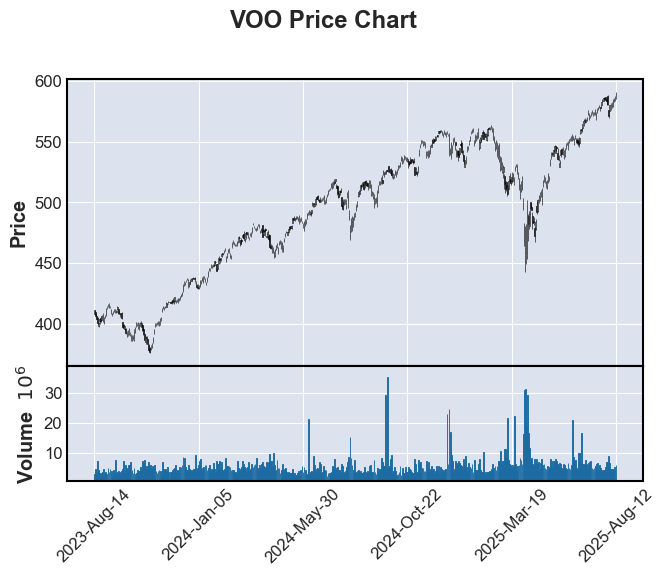

In [12]:
url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/day/{previous_date}/{today_date}"

params = {
    "adjusted": "true",
    "sort": "asc",
    "limit": 600,
    "apiKey": API_KEY
}

response = requests.get(url, params=params)
data = response.json()

if "results" not in data:
    print("Error or no results:", data)
else:
    df = pd.DataFrame(data["results"])
    df["t"] = pd.to_datetime(df["t"], unit="ms")
    df.set_index("t", inplace=True)

    df = df.rename(columns={
        "o": "Open",
        "h": "High",
        "l": "Low",
        "c": "Close",
        "v": "Volume"
    })

    df = df[["Open", "High", "Low", "Close", "Volume"]]

    mpf.plot(df, type="candle", volume=True, title=f"{ticker} Price Chart")


In [15]:
data = pd.DataFrame(data)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
data['results']

0          {'v': 2772912.0, 'vw': 410.319, 'o': 408.56, 'c': 411.72, 'h': 411.74, 'l': 408.31, 't': 1691985600000, 'n': 77649}
1          {'v': 4686119.0, 'vw': 414.2162, 'o': 410.09, 'c': 407, 'h': 411.7125, 'l': 406.41, 't': 1692072000000, 'n': 95304}
2         {'v': 3353653.0, 'vw': 405.9405, 'o': 406.59, 'c': 403.99, 'h': 408.11, 'l': 403.87, 't': 1692158400000, 'n': 97757}
3        {'v': 7102504.0, 'vw': 402.4129, 'o': 405.33, 'c': 400.72, 'h': 405.58, 'l': 400.37, 't': 1692244800000, 'n': 107202}
4        {'v': 4157667.0, 'vw': 399.9369, 'o': 398.17, 'c': 401.09, 'h': 402.02, 'l': 397.85, 't': 1692331200000, 'n': 111613}
                                                                ...                                                           
496      {'v': 4545015.0, 'vw': 580.5482, 'o': 578.25, 'c': 581.64, 'h': 582.27, 'l': 577.41, 't': 1754452800000, 'n': 167339}
497    {'v': 4594260.0, 'vw': 581.2844, 'o': 584.87, 'c': 581.29, 'h': 585.52, 'l': 578.3127, 't': 175453920000

In [16]:
results = pd.json_normalize(data["results"])
flattened_results = pd.concat([data.reset_index(drop=True), results], axis=1)
historical_data = flattened_results[['ticker','vw', 'o', 'h', 'l', 'c', 'v','t','n']]
historical_data['datetime'] = pd.to_datetime(historical_data['t'], unit='ms')
historical_data = historical_data.set_index('datetime')
historical_data.head()

/var/folders/kw/2qkht0_n5ksdwhs1fsbt95pw0000gn/T/ipykernel_29420/2129047425.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_data['datetime'] = pd.to_datetime(historical_data['t'], unit='ms')


,ticker,vw,o,h,l,c,v,t,n
datetime,,,,,,,,,
2023-08-14 04:00:00,VOO,410.3190,408.56,411.7400,408.31,411.72,2772912.0,1691985600000,77649
2023-08-15 04:00:00,VOO,414.2162,410.09,411.7125,406.41,407.00,4686119.0,1692072000000,95304
2023-08-16 04:00:00,VOO,405.9405,406.59,408.1100,403.87,403.99,3353653.0,1692158400000,97757
2023-08-17 04:00:00,VOO,402.4129,405.33,405.5800,400.37,400.72,7102504.0,1692244800000,107202
2023-08-18 04:00:00,VOO,399.9369,398.17,402.0200,397.85,401.09,4157667.0,1692331200000,111613


In [19]:
from __future__ import annotations

def compute_indicators(
    df: pd.DataFrame,
    price_col: str = "vw",
    window_short: int = 10,
    window_long: int = 50,
    ) -> pd.DataFrame:
    """Compute technical indicators often used in professional quantitative trading.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing price data.
    price_col : str, default "vw"
        Column name for the price series.
    window_short : int, default 10
        Short-term window size for moving averages.
    window_long : int, default 50
        Long-term window size for moving averages.

    Returns
    -------
    pd.DataFrame
        Original DataFrame with added indicator columns, including:
        - ret_1: 1-period returns
        - sma_short, sma_long: Simple moving averages
        - ema_short, ema_long: Exponential moving averages
        - momentum: Relative difference between short and long SMA
        - vol_20: Annualized volatility (20-day rolling)
        - rsi: 14-day relative strength index
        - macd, macd_signal: MACD line and signal line
        - zscore_20: 20-day rolling z-score of price
        - skew_20, kurt_20: 20-day rolling skewness and kurtosis
    """
    df = df.copy()
    price = df[price_col]

    # Basic returns and averages
    df["ret_1"] = price.pct_change()
    df["sma_short"] = price.rolling(window_short, min_periods=1).mean()
    df["sma_long"] = price.rolling(window_long, min_periods=1).mean()
    df["ema_short"] = price.ewm(span=window_short, adjust=False).mean()
    df["ema_long"] = price.ewm(span=window_long, adjust=False).mean()

    # Momentum
    df["momentum"] = (df["sma_short"] - df["sma_long"]) / df["sma_long"]

    # Volatility (annualized)
    df["vol_20"] = df["ret_1"].rolling(20, min_periods=1).std() * np.sqrt(252)

    # RSI (14-day)
    delta = price.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(14, min_periods=1).mean()
    roll_down = down.rolling(14, min_periods=1).mean()
    rs = roll_up / (roll_down + 1e-12)
    df["rsi"] = 100 - (100 / (1 + rs))

    # MACD (12, 26, 9)
    ema_12 = price.ewm(span=12, adjust=False).mean()
    ema_26 = price.ewm(span=26, adjust=False).mean()
    df["macd"] = ema_12 - ema_26
    df["macd_signal"] = df["macd"].ewm(span=9, adjust=False).mean()

    # Z-score of price (20-day)
    rolling_mean = price.rolling(20, min_periods=1).mean()
    rolling_std = price.rolling(20, min_periods=1).std(ddof=0)
    df["zscore_20"] = (price - rolling_mean) / (rolling_std + 1e-12)

    # Higher moments: skewness, kurtosis
    df["skew_20"] = (
        price.rolling(20, min_periods=1).apply(lambda x: pd.Series(x).skew(), raw=False)
    )
    df["kurt_20"] = (
        price.rolling(20, min_periods=1).apply(lambda x: pd.Series(x).kurt(), raw=False)
    )

    return df.dropna()


def plot_indicators(indicators_df: pd.DataFrame) -> None:
    """Plot key technical indicators from the computed indicators DataFrame.

    Parameters
    ----------
    indicators_df : pd.DataFrame
        DataFrame with DateTimeIndex containing price and technical indicators.
    """
    fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

    plot_configs = [
        {
            "title": "Price & Moving Averages",
            "plots": [
                ("vw", "VWAP", "black", "-"),
                ("sma_short", "SMA Short", "blue", "-"),
                ("sma_long", "SMA Long", "red", "-"),
                ("ema_short", "EMA Short", "cyan", "--"),
                ("ema_long", "EMA Long", "magenta", "--"),
            ],
            "hline": None,
        },
        {
            "title": "Momentum",
            "plots": [("momentum", "Momentum", "green", "-")],
            "hline": 0,
        },
        {
            "title": "MACD",
            "plots": [
                ("macd", "MACD", "purple", "-"),
                ("macd_signal", "Signal", "orange", "-"),
            ],
            "hline": 0,
        },
    ]

    # Loop through first 3 subplots
    for ax, config in zip(axs[:3], plot_configs):
        for col, label, color, style in config["plots"]:
            ax.plot(indicators_df.index, indicators_df[col], label=label, color=color, linestyle=style)
        if config["hline"] is not None:
            ax.axhline(config["hline"], color="gray", linestyle="--")
        ax.set_title(config["title"])
        ax.legend()
        ax.grid(True)

    # Volatility + RSI panel
    axs[3].plot(indicators_df.index, indicators_df["vol_20"], label="Volatility (20d)", color="brown")
    ax2 = axs[3].twinx()
    ax2.plot(indicators_df.index, indicators_df["rsi"], label="RSI (14)", color="blue")
    ax2.set_ylim(0, 110)
    axs[3].set_title("Volatility & RSI")
    axs[3].grid(True)

    # Combine legends for last subplot
    lines, labels = axs[3].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    axs[3].legend(lines + lines2, labels + labels2, loc="center left", bbox_to_anchor=(1.1, 0.5))

    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()


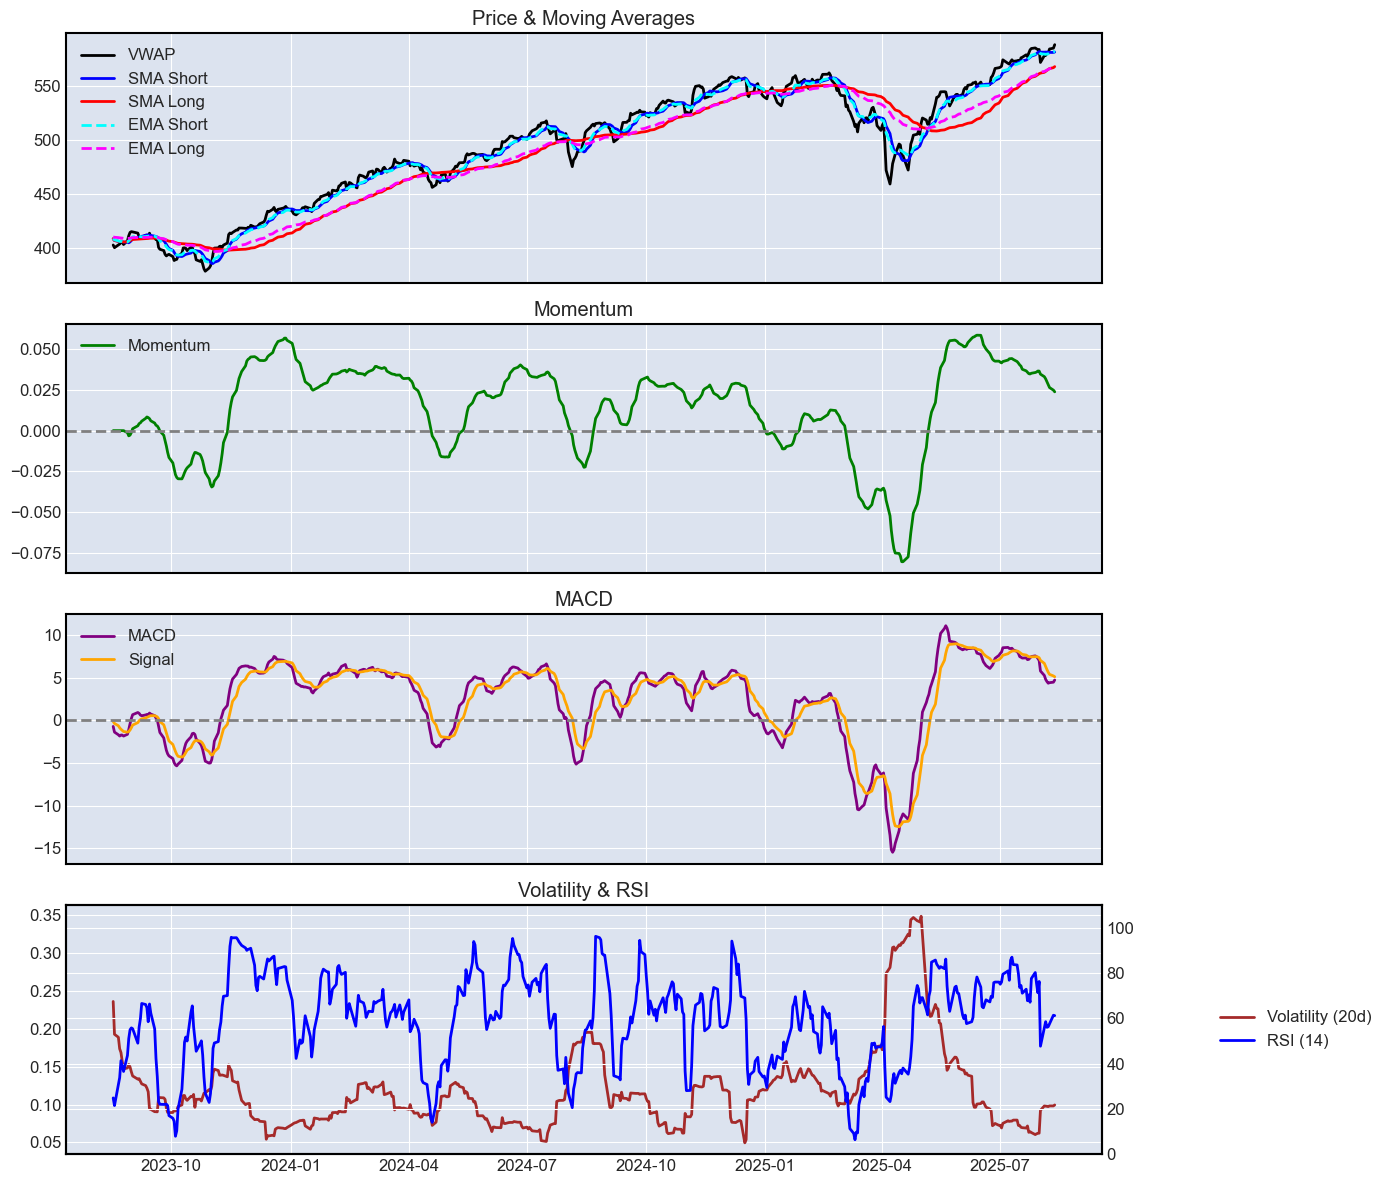

In [20]:
indicators = compute_indicators(historical_data, price_col='vw')
plot_indicators(indicators)

In [ ]:

# -------------------------
# Black-Scholes helpers (European approx)
# -------------------------

def bs_price(S, K, r, q, sigma, tau, option_type='call'):
    if tau <= 0:
        # intrinsic
        return max(0.0, (S - K)) if option_type == 'call' else max(0.0, (K - S))
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    if option_type == 'call':
        return S * np.exp(-q * tau) * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    else:
        return K * np.exp(-r * tau) * norm.cdf(-d2) - S * np.exp(-q * tau) * norm.cdf(-d1)


def bs_delta(S, K, r, q, sigma, tau, option_type='call'):
    if tau <= 0:
        return 1.0 if (option_type == 'call' and S > K) else 0.0
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    if option_type == 'call':
        return np.exp(-q * tau) * norm.cdf(d1)
    else:
        return -np.exp(-q * tau) * norm.cdf(-d1)
    
# -------------------------
# Monte Carlo underlying paths (GBM)
# -------------------------

def simulate_gbm_paths(S0, mu, sigma, T, steps, n_paths, random_state=None):
    dt = T / steps
    rng = np.random.default_rng(random_state)
    increments = rng.normal(loc=(mu - 0.5 * sigma ** 2) * dt, scale=sigma * np.sqrt(dt), size=(n_paths, steps))
    log_paths = np.cumsum(increments, axis=1)
    log_paths = np.concatenate((np.zeros((n_paths, 1)), log_paths), axis=1)
    S = S0 * np.exp(log_paths)
    return S

# -------------------------
# Hedged option P/L simulation
# -------------------------

def simulate_option_pnl(option_meta, S0, r, q, implied_sigma, days_to_expiry, historical_vol, n_sim=2000, rebalance_days=1, random_state=None):
    """Simulate delta-hedged option P/L over life using GBM paths.
    - option_meta: dict containing strike_price, contract_type ('call'/'put'), shares_per_contract
    - S0: initial underlying price
    - r, q: rates (annual)
    - implied_sigma: use for initial pricing and as model sigma if desired
    - historical_vol: annual vol estimate for path generation (or implied)
    - days_to_expiry: integer trading days
    Returns PnL array across sims (per contract)
    """
    T = days_to_expiry / 252
    steps = max(1, int(days_to_expiry / rebalance_days))
    K = option_meta['strike_price']
    option_type = option_meta['contract_type']
    n_paths = n_sim
    sigma = historical_vol if historical_vol is not None else implied_sigma
    paths = simulate_gbm_paths(S0, mu=0.0, sigma=sigma, T=T, steps=steps, n_paths=n_paths, random_state=random_state)
    taus = np.linspace(T, 0, steps + 1)
    pnl = np.zeros(n_paths)
    contract_multiplier = option_meta.get('shares_per_contract', 100)
    # initial option price and delta
    opt_price0 = bs_price(S0, K, r, q, implied_sigma, T, option_type)
    delta0 = bs_delta(S0, K, r, q, implied_sigma, T, option_type)
    # assume initial hedge: short delta underlying, finance with cash at r
    for i in range(n_paths):
        cash = opt_price0  # receive premium if selling; if buying, set -opt_price0
        position_underlying = -delta0  # hedge: short delta per option
        cash -= position_underlying * S0  # buying/selling underlying costs
        # iterate rebalancing
        for t in range(1, steps + 1):
            St_prev = paths[i, t-1]
            St = paths[i, t]
            tau = taus[t]
            # option reprice using implied_sigma (we keep fixed vol surface)
            price_prev = bs_price(St_prev, K, r, q, implied_sigma, tau + (T/steps - T/steps), option_type)
            # compute new delta
            new_delta = bs_delta(St, K, r, q, implied_sigma, tau, option_type)
            # rebalance: buy (new_delta - old_delta) underlying at price St
            trade = -(new_delta - position_underlying)
            cash -= trade * St
            position_underlying = -new_delta
            # cash accrues at risk-free rate for dt
            dt = (T / steps)
            cash *= np.exp(r * dt)
        # at expiry, close underlying and option payoff
        final_S = paths[i, -1]
        option_payoff = max(0.0, (final_S - K)) if option_type == 'call' else max(0.0, (K - final_S))
        cash_flow = cash - position_underlying * final_S  # close underlying
        # net P/L per option contract (note: if we sold option initially, interpret accordingly)
        # Here we simulated selling the option; if user buys option, invert sign
        pnl[i] = cash_flow - option_payoff
        # scale by shares per contract
        pnl[i] = pnl[i] * contract_multiplier
    return pnl

# -------------------------
# Bayesian-ish probability of success using logistic + Laplace approx
# -------------------------

def train_logistic_with_cov(X, y):
    """Train logistic regression using statsmodels to get covariance for coefficients.
    Returns fitted model and (coef_mean, cov)
    """
    Xc = sm.add_constant(X)
    model = sm.Logit(y, Xc).fit(disp=0)
    coef = model.params.values
    cov = model.cov_params().values
    return model, coef, cov


def posterior_predictive_prob(model_coef_mean, model_coef_cov, x_new, n_samples=2000, random_state=None):
    rng = np.random.default_rng(random_state)
    samples = rng.multivariate_normal(mean=model_coef_mean, cov=model_coef_cov, size=n_samples)
    X_new = np.concatenate(([1.0], x_new))
    logits = samples.dot(X_new)
    probs = 1 / (1 + np.exp(-logits))
    return probs  # samples of predicted probability

# -------------------------
# Risk metrics: CVaR & Sharpe
# -------------------------

def cvar(returns, alpha=0.95):
    # returns: P/L realizations (positive profit). For CVaR of losses use negative returns
    losses = -np.array(returns)
    cutoff = np.quantile(losses, alpha)
    tail_losses = losses[losses >= cutoff]
    if len(tail_losses) == 0:
        return np.mean(losses)
    return tail_losses.mean()


def sharpe_ratio(returns, periods_per_year=252):
    r = np.array(returns)
    mu = r.mean()
    sigma = r.std(ddof=1)
    if sigma == 0:
        return np.nan
    return (mu / sigma) * np.sqrt(periods_per_year)

# -------------------------
# Helper: assemble features and scoring for a candidate option
# -------------------------

def score_option_candidate(option_meta, underlying_df, as_of_date, r=0.01, q=0.0, n_sim=2000):
    """Compute indicators up to as_of_date, train simple logistic on historical labeled outcomes (if any),
    then simulate option P/L and return probability of profitable trade + metrics.

    This function assumes underlying_df has columns computed by compute_indicators and historical labeled rows
    where 'success' column indicates prior trades. For demonstration we will use a naive approach:
    - features: last momentum, vol, rsi
    - train logistic if 'success' exists
    - simulate P/L
    """
    # prepare features
    hist = underlying_df.loc[:as_of_date].copy()
    last = hist.iloc[-1]
    features = np.array([last['momentum'], last['vol_20'], last['rsi']])
    # train logistic if success label exists
    if 'success' in underlying_df.columns:
        df_train = underlying_df.dropna(subset=['momentum', 'vol_20', 'rsi', 'success']).copy()
        X = df_train[['momentum', 'vol_20', 'rsi']].values
        y = df_train['success'].astype(int).values
        model, coef_mean, coef_cov = train_logistic_with_cov(X, y)
        pp_samples = posterior_predictive_prob(coef_mean, coef_cov, features, n_samples=1000)
        prob_success_model = pp_samples.mean()
    else:
        prob_success_model = np.nan
    # estimate vol from history
    hist_vol = last['vol_20']
    days_to_expiry = (pd.to_datetime(option_meta['expiration_date']) - pd.to_datetime(as_of_date)).days
    days_to_expiry = max(1, days_to_expiry)
    pnl_sims = simulate_option_pnl(option_meta, S0=last['vw'], r=r, q=q, implied_sigma=option_meta.get('implied_volatility', hist_vol),
                                   days_to_expiry=days_to_expiry, historical_vol=hist_vol, n_sim=n_sim)
    prob_profit_sim = np.mean(pnl_sims > 0)
    expected_pnl = np.mean(pnl_sims)
    cvar_95 = cvar(pnl_sims, alpha=0.95)
    sharpe = sharpe_ratio(pnl_sims)
    return {
        'prob_success_model': prob_success_model,
        'prob_profit_sim': prob_profit_sim,
        'expected_pnl': expected_pnl,
        'cvar_95': cvar_95,
        'sharpe': sharpe,
        'pnl_sims': pnl_sims  # can be large
    }

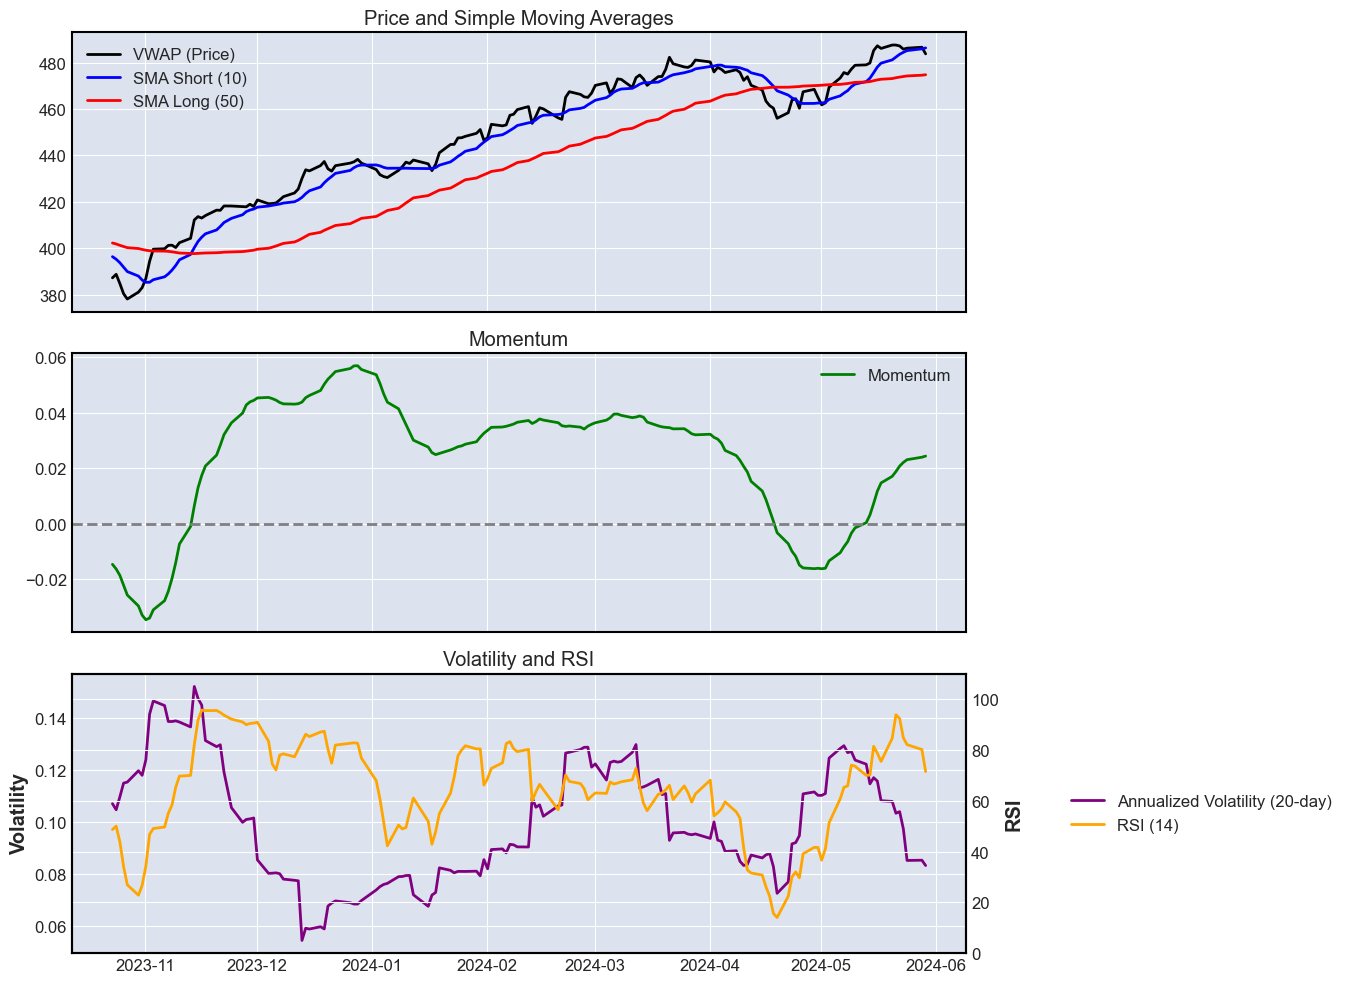

In [ ]:
def plot_indicators(indicators_df):
    """Plot VWAP, SMAs, Momentum, Volatility, and RSI from an indicators DataFrame.

    Parameters
    ----------
    indicators_df : pandas.DataFrame
        DataFrame with DateTimeIndex and required columns:
        ['vw', 'sma_short', 'sma_long', 'momentum', 'vol_20', 'rsi']
    """
    fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

    plot_data = [
        [
            ("vw", "VWAP (Price)", "black"),
            ("sma_short", "SMA Short (10)", "blue"),
            ("sma_long", "SMA Long (50)", "red")
        ],
        [
            ("momentum", "Momentum", "green")
        ]
    ]

    titles = [
        "Price and Simple Moving Averages",
        "Momentum",
        "Volatility and RSI"
    ]

    # Loop through first two subplots
    for ax, plots, title in zip(axs[:2], plot_data, titles[:2]):
        for col, label, color in plots:
            ax.plot(indicators_df.index, indicators_df[col], label=label, color=color)
        if title == "Momentum":
            ax.axhline(0, color='gray', linestyle='--')
        ax.set_title(title)
        ax.legend()
        ax.grid(True)

    # Third subplot (special handling for twin axis)
    axs[2].plot(indicators_df.index, indicators_df['vol_20'], label='Annualized Volatility (20-day)', color='purple')
    axs[2].set_ylabel('Volatility')
    ax2 = axs[2].twinx()
    ax2.plot(indicators_df.index, indicators_df['rsi'], label='RSI (14)', color='orange')
    ax2.set_ylabel('RSI')
    axs[2].set_title(titles[2])
    axs[2].grid(True)

    # Combine legends for last subplot
    lines, labels = axs[2].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.set_ylim(0, 110)
    axs[2].legend(lines + lines2, labels + labels2, loc='center left', bbox_to_anchor=(1.1, 0.5))

    plt.xlabel('Date')
    plt.tight_layout(rect=[0, 0, 1, 1.2])
    plt.show()
